In [1]:
from main import *

from sklearn.model_selection import train_test_split
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
machines = ["M01", "M02","M03"]
process_names = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]
labels = ["good","bad"]
path_to_dataset = Path("./data/").absolute()

In [3]:
X_data = []
y_data = []

for process_name, machine, label in itertools.product(process_names, machines, labels):
    data_path = os.path.join(path_to_dataset, machine, process_name, label)
    data_list, data_label = data_loader_utils.load_tool_research_data(data_path, label=label, add_additional_label = True, verbose = False)
    #concatenating
    X_data.extend(data_list)
    y_data.extend(data_label)

In [4]:
X = [x.astype(np.float64) for x in X_data] # Ensure all examples have the same datatype
X = np.array([x[:4096, :3] for x in X]) # Select the first 4096 timesteps of all three dimensions for each row
y = np.array([0 if id.split("_")[-1] == "good" else 1 for id in y_data])

# Reshape X into a dataframe that is compatible with MiniRocket transform
axis = ["X-axis", "Y-axis", "Z-axis"] 
axisdict = {"X-axis": [], "Y-axis":[],  "Z-axis":[]}
for i, ax in enumerate(axis):
    for n in range(X.shape[0]):
        axisdict[ax].append(pd.Series(X[n][:,i]))

X_df = pd.DataFrame(axisdict)

In [5]:
# Train Test split with 0.2 train size and 0.8 test_size
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.8, stratify = y)

X_train.shape, X_test.shape

((340, 3), (1362, 3))

In [6]:
# Fitting MiniRocket
trf = MiniRocketMultivariate(n_jobs = -1) 
trf.fit(X_train)

/home/tinus/sktime/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


MiniRocketMultivariate(n_jobs=-1)

In [7]:
# Transforming X_train independently 
X_train_trf = trf.transform(X_train)
X_test_trf = trf.transform(X_test) 

In [8]:
# Fitting the classifier
clf = LogisticRegression()

clf.fit(X_train_trf, y_train)
y_pred = clf.predict(X_test_trf)
f1_score(y_test, y_pred)

0.9911504424778761

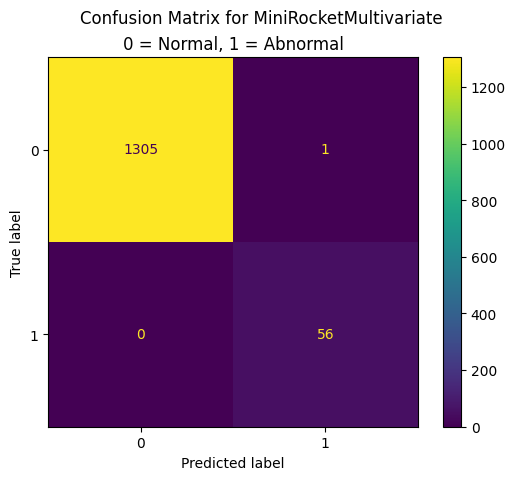

In [9]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.suptitle("Confusion Matrix for MiniRocketMultivariate")
plt.title("0 = Normal, 1 = Abnormal") 
plt.savefig("plots/cmMiniRocket.png")
plt.show()
